In [21]:
import arcpy
import arcview
from arcpy import env
import numpy as np
import matplotlib.pyplot as plt
import gdal

In [22]:
# Functions below can be found at: 
# https://github.com/RuiGao92/Rui_Python_Functions_Package
%run D:\...\FolderCreater.py
%run D:\...\TellExtent.py
%run D:\...\WriteTiffData.py
%run C:\...\TellTheGeoInfo.py

# Define parameters and folder paths

In [23]:
# Name used for naming mid-products
Flight_Date = "20190813"
# Shapefile provided by user and the calculation will be calculated based on this file
Research_Grids = r'D:\...\Wellsville_Grids_1m_20190813.shp'
# Image gained from the AggieAir platform
AggieAir_Spectral = r'C:\...\20190813_wellsville_captain_004_10000_6bands.tif'
# Results and the mid-products will be saved in this folder
dir_output = r'D:\...\Results_190813'
FolderCreater(dir_output)

CellSize = "0.1 0.1"
NoDataValue_1 = -9999
NoDataValue_2 = np.nan
# band number of the image
band_G = 1
band_R = 0
band_RE = 3
band_NIR = 4
band_Tr = 5
# grid size of the shapefile
GridSize = 1 # meter
# different type of canopy heights
# This part need to be re-defined in the right section again, and this part could be deleted
h_corn = 2.5
h_alf = 0.2
h_mar = 1.1
h_road = 0
# give imperical values avoiding inf values
LAI_max_value = 4.5
w_h_ratio_max = 10
ci_re_max = 10 # maximum value CI_re (VI) should be smaller than 10 (empirical)

# Image pre-processing
Resample and align the image data. After this process, gain the image results for TSEB model.

In [24]:
# Resample
arcpy.Resample_management(in_raster=AggieAir_Spectral, 
                          out_raster=dir_output+"\\"+Flight_Date+"_res.tif", 
                          cell_size=CellSize, 
                          resampling_type="NEAREST")
rectangle_extent = TellExtent(Research_Grids)
# Align the image with the grids
arcpy.Clip_management(in_raster=dir_output+"\\"+Flight_Date+"_res.tif", 
                      rectangle=rectangle_extent, 
                      out_raster=dir_output+"\\"+Flight_Date+"_clip.tif", 
                      in_template_dataset=Research_Grids, 
                      nodata_value=NoDataValue_1, 
                      clipping_geometry="NONE", maintain_clipping_extent="MAINTAIN_EXTENT")

The extent is: 423220.5553930541 4612315.669819682 423836.5553930541 4612809.669819682


<Result 'D:\\Project_Wellsville\\12_Oliver_Results\\Results_190813\\20190813_clip.tif'>

# Vegetation index calculation
Using NDVI to recognize the soil and vegetation, and also export several VIs raster data.

In [25]:
# get the information from the cliped imagery
# resolution is 0.1*0.1
[dims,img_geo,img_prj] = TellTheGeoInfo(dir_output+"\\"+Flight_Date+"_clip.tif")

Dimension of the data is: 4940 6160


C:\Users\grui9\anaconda3\envs\TSEB\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


D:\Project_Wellsville\12_Oliver_Results\Results_190813\20190813_NDVI.tif
Done!!! Tiff data has been written.
D:\Project_Wellsville\12_Oliver_Results\Results_190813\20190813_CI_re.tif
Done!!! Tiff data has been written.


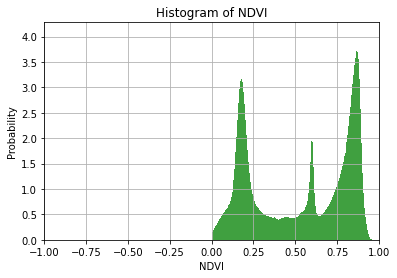

In [26]:
# NDVI calculation and histogram
# CI_RE calculation for LAI calculation for Corn
Array_Spectral = arcpy.RasterToNumPyArray(dir_output+"\\"+Flight_Date+"_clip.tif", 
                                          nodata_to_value=NoDataValue_2)
NDVI = (Array_Spectral[band_NIR,:,:]-Array_Spectral[band_R,:,:])/(Array_Spectral[band_NIR,:,:]+Array_Spectral[band_R,:,:])
# ignore the negative values
NDVI[NDVI<0] = 0
CI_RE = Array_Spectral[band_NIR,:,:]/Array_Spectral[band_RE,:,:]-1
CI_RE[CI_RE >= ci_re_max] = NoDataValue_2

WriteTiffData(dir_output, Flight_Date+"_NDVI", dims[0], dims[1], NDVI, img_geo, img_prj)
WriteTiffData(dir_output, Flight_Date+"_CI_re", dims[0], dims[1], CI_RE, img_geo, img_prj)

# the histogram of the data
NDVI_hist = NDVI.reshape(-1)
n, bins, patches = plt.hist(NDVI_hist, 1000, density=True, facecolor='g', alpha=0.75)
plt.xlabel('NDVI')
plt.ylabel('Probability')
plt.title('Histogram of NDVI')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(-1, 1)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

# Fractional cover and canopy width
We need manually to find the threshold to defind the vegetation index. This is the only one parameter we defined in the middle of this script.

In [28]:
# NDVI threshold from histogram for vegetation
NDVI_threshold = 0.35

In [29]:
# Using the threshold to identify the vegetation pixel and non-vegetation index
Veg_logic = NDVI.copy()
Veg_logic[Veg_logic >= NDVI_threshold] = 1
Veg_logic[Veg_logic < NDVI_threshold] = 0
WriteTiffData(dir_output, Flight_Date+"_Veg", dims[0], dims[1], Veg_logic, img_geo, img_prj)

D:\Project_Wellsville\12_Oliver_Results\Results_190813\20190813_Veg.tif
Done!!! Tiff data has been written.


()

In [30]:
# Zonal statistics as table - for fractional cover
arcpy.gp.ZonalStatisticsAsTable_sa(Research_Grids, "FID", dir_output+"\\"+Flight_Date+"_Veg.tif", 
                                   dir_output+"\\"+Flight_Date+"_Zonal.dbf", "DATA", "SUM")
arcpy.AddField_management(dir_output+"\\"+Flight_Date+"_Zonal.dbf", 
                          "FC", "FLOAT")
arcpy.CalculateField_management(in_table=dir_output+"\\"+Flight_Date+"_Zonal.dbf", 
                                field="FC", 
                                expression="!SUM! / !COUNT!", 
                                expression_type="PYTHON_9.3", code_block="")

<Result 'D:\\Project_Wellsville\\12_Oliver_Results\\Results_190813\\20190813_Zonal.dbf'>

In [31]:
# Join the table and then output it as a raster 
arcpy.JoinField_management(in_data=Research_Grids, 
                           in_field="FID", 
                           join_table=dir_output+"\\"+Flight_Date+"_Zonal.dbf", 
                           join_field="OID", 
                           fields="FC")

<Result 'D:\\Project_Wellsville\\12_Oliver_Results\\Grids_shp\\Wellsville_Grids_1m_20190813.shp'>

In [32]:
# output the fractional cover and canopy width as raster format
arcpy.FeatureToRaster_conversion(in_features=Research_Grids, 
                                 field="FC", 
                                 out_raster=dir_output+"\\"+Flight_Date+"_Fc.tif", 
                                 cell_size=GridSize)
# This one works only when the grid size is 1 meter
arcpy.FeatureToRaster_conversion(in_features=Research_Grids, 
                                 field="FC", 
                                 out_raster=dir_output+"\\"+Flight_Date+"_C_w.tif", 
                                 cell_size=GridSize)

<Result 'D:\\Project_Wellsville\\12_Oliver_Results\\Results_190813\\20190813_C_w.tif'>

# Canopy height 
Manually assign canopy height based on the objectives

In [33]:
# assign canopy height for different canopy type
arcpy.management.CalculateField(Research_Grids,
                                "Ch", 
                                "canopyheight(!Id!)", 
                                "PYTHON3", 
                                """def canopyheight(ID):
    if ID == 1:
        hc = 2.5
    elif ID == 2:
        hc = 0.2
    elif ID == 3:
        hc = 0.2
    elif ID == 4:
        hc = 1.1
    elif ID == 5:
        hc = 0
    elif ID == 6:
        hc = 0
    return(hc)""", "DOUBLE")
arcpy.FeatureToRaster_conversion(in_features=Research_Grids, 
                                 field="Ch", 
                                 out_raster=dir_output+"\\"+Flight_Date+"_C_h.tif", 
                                 cell_size=GridSize)

<Result 'D:\\Project_Wellsville\\12_Oliver_Results\\Results_190813\\20190813_C_h.tif'>

# The ratio between canopy width and canopy height

In [34]:
# resolution is 1*1 meter
[dims,img_geo,img_prj] = TellTheGeoInfo(dir_output+"\\"+Flight_Date+"_C_w.tif")
Array_width = arcpy.RasterToNumPyArray(dir_output+"\\"+Flight_Date+"_C_w.tif", 
                                          nodata_to_value=NoDataValue_1)
Array_height = arcpy.RasterToNumPyArray(dir_output+"\\"+Flight_Date+"_C_h.tif", 
                                          nodata_to_value=NoDataValue_1)
Array_ratio = Array_width/Array_height
Array_ratio[Array_ratio>w_h_ratio_max]=w_h_ratio_max

WriteTiffData(dir_output, Flight_Date+"_w_h", dims[0], dims[1], Array_ratio, img_geo, img_prj)

Dimension of the data is: 494 616
D:\Project_Wellsville\12_Oliver_Results\Results_190813\20190813_w_h.tif
Done!!! Tiff data has been written.


C:\Users\grui9\anaconda3\envs\TSEB\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
C:\Users\grui9\anaconda3\envs\TSEB\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


()

# LAI estimation
Need to manually modify the LAI value based on the canopy type

In [35]:
# Zonal statistics as table
# "MEAN", the last parameter represents the "percentile interpolation type"
arcpy.gp.ZonalStatisticsAsTable_sa(Research_Grids, "FID", dir_output+"\\"+Flight_Date+"_CI_re.tif", 
                                   dir_output+"\\"+Flight_Date+"_CIreAvg.dbf", "DATA", "MEAN")
arcpy.gp.ZonalStatisticsAsTable_sa(Research_Grids, "FID", dir_output+"\\"+Flight_Date+"_NDVI.tif", 
                                   dir_output+"\\"+Flight_Date+"_NDVIAvg.dbf", "DATA", "MEAN")

<geoprocessing server result object at 0x259866e26c0>

In [36]:
# join the field
arcpy.management.JoinField(Research_Grids, 
                           "FID", 
                           dir_output+"\\"+Flight_Date+"_CIreAvg.dbf", 
                           "OID", 
                           "MEAN")
arcpy.management.JoinField(Research_Grids, 
                           "FID", 
                           dir_output+"\\"+Flight_Date+"_NDVIAvg.dbf", 
                           "OID", 
                           "MEAN")
# "MEAN" in this table represents CI_re, and "MEAN_1" NDVI

<Result 'D:\\Project_Wellsville\\12_Oliver_Results\\Grids_shp\\Wellsville_Grids_1m_20190813.shp'>

In [37]:
# feature to raster
arcpy.conversion.FeatureToRaster(in_features=Research_Grids, 
                                 field="MEAN", 
                                 out_raster=dir_output+"\\"+Flight_Date+"_CIre_Avg.tif", 
                                 cell_size=GridSize)
arcpy.conversion.FeatureToRaster(in_features=Research_Grids, 
                                 field="MEAN_1", 
                                 out_raster=dir_output+"\\"+Flight_Date+"_NDVI_Avg.tif", 
                                 cell_size=GridSize)

<Result 'D:\\Project_Wellsville\\12_Oliver_Results\\Results_190813\\20190813_NDVI_Avg.tif'>

In [38]:
# point to raster
# assign canopy height for different canopy type
# ID == 1: corn
# ID == 2 and/or 3: alfalfa
# ID == 4: marijuana
# ID == 5: road
# ID == 6: unknown place
arcpy.management.CalculateField(Research_Grids, 
                                "LAI", 
                                "laicalculation(!Id!,!MEAN!,!MEAN_1!)", 
                                "PYTHON3", 
                                """def laicalculation(ID,CI_re,NDVI):
    if ID == 1:
        laifc = 0.5574*CI_re+0.5617
    elif ID == 2:
        laifc = 3.5255*NDVI**1.8485
    elif ID == 3:
        laifc = 3.5255*NDVI**1.8485
    elif ID == 4:
        laifc = 0.2853*CI_re+0.2604
    elif ID == 5:
        laifc = 0
    elif ID == 6:
        laifc = 0
    return(laifc)""", "DOUBLE")

<Result 'D:\\Project_Wellsville\\12_Oliver_Results\\Grids_shp\\Wellsville_Grids_1m_20190813.shp'>

In [39]:
# write feature to raster
# output the LAI*Fc as an image - LAI*Fc is the LAI value for the domain
arcpy.conversion.FeatureToRaster(in_features=Research_Grids, 
                                 field="LAI", 
                                 out_raster=dir_output+"\\"+Flight_Date+"_LAI_tmp.tif", 
                                 cell_size=GridSize)
# force negative LAI values to 0
Array_LAI = arcpy.RasterToNumPyArray(dir_output+"\\"+Flight_Date+"_LAI_tmp.tif", 
                                          nodata_to_value=NoDataValue_1)
Array_LAI[Array_LAI<0] = 0
Array_LAI[Array_LAI>LAI_max_value] = LAI_max_value
WriteTiffData(dir_output, Flight_Date+"_LAI", dims[0], dims[1], Array_LAI, img_geo, img_prj)

D:\Project_Wellsville\12_Oliver_Results\Results_190813\20190813_LAI.tif
Done!!! Tiff data has been written.


()

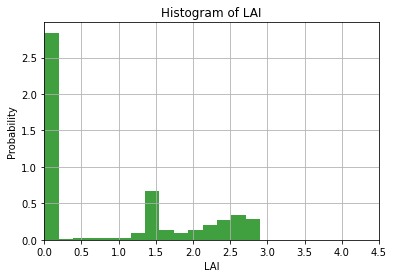

In [40]:
# the histogram of the LAI
LAI_hist = Array_LAI.reshape(-1)
n, bins, patches = plt.hist(LAI_hist, 15, density=True, facecolor='g', alpha=0.75)
plt.xlabel('LAI')
plt.ylabel('Probability')
plt.title('Histogram of LAI')
plt.xlim(0, LAI_max_value)
plt.grid(True)
plt.show()

# Upscaling the thermal data

In [41]:
# extract thermal band from the original bands
[dims,img_geo,img_prj] = TellTheGeoInfo(AggieAir_Spectral)
Array_tr_tmp = arcpy.RasterToNumPyArray(AggieAir_Spectral,
                                        nodata_to_value=NoDataValue_2)
WriteTiffData(dir_output, Flight_Date+"_Tr", dims[0], dims[1], Array_tr_tmp[band_Tr,:,:], img_geo, img_prj)
# upscale to energy level
Array_tr_cal = arcpy.RasterToNumPyArray(dir_output+"\\"+Flight_Date+"_Tr.tif",
                                        nodata_to_value=NoDataValue_2)
Array_tr_cal = (Array_tr_cal + 273.15)**4 # unit of the original thermal data is degree C
WriteTiffData(dir_output, Flight_Date+"_Tr_Energy", dims[0], dims[1], Array_tr_cal, img_geo, img_prj)

Dimension of the data is: 8443 10601
D:\Project_Wellsville\12_Oliver_Results\Results_190813\20190813_Tr.tif
Done!!! Tiff data has been written.
D:\Project_Wellsville\12_Oliver_Results\Results_190813\20190813_Tr_Energy.tif
Done!!! Tiff data has been written.


()

In [42]:
# adjust the grid size on the energy level
arcpy.Resample_management(dir_output+"\\"+Flight_Date+"_Tr_Energy.tif", 
                          out_raster=dir_output+"\\"+Flight_Date+"_Tr_res.tif",
                          cell_size=GridSize, 
                          resampling_type="NEAREST")
arcpy.Clip_management(in_raster=dir_output+"\\"+Flight_Date+"_Tr_res.tif",
                      rectangle=rectangle_extent, 
                      out_raster=dir_output+"\\"+Flight_Date+"_Tr_Cliped.tif", 
                      in_template_dataset=Research_Grids, 
                      nodata_value=NoDataValue_1, 
                      clipping_geometry="NONE", maintain_clipping_extent="MAINTAIN_EXTENT")

<Result 'D:\\Project_Wellsville\\12_Oliver_Results\\Results_190813\\20190813_Tr_Cliped.tif'>

In [43]:
[dims,img_geo,img_prj] = TellTheGeoInfo(dir_output+"\\"+Flight_Date+"_Tr_Cliped.tif",)
Array_tr_cal = arcpy.RasterToNumPyArray(dir_output+"\\"+Flight_Date+"_Tr_Cliped.tif",
                                        nodata_to_value=NoDataValue_2)
Array_tr_cal = np.sqrt(np.sqrt(Array_tr_cal))
WriteTiffData(dir_output, Flight_Date+"_Tr_Final", dims[0], dims[1], Array_tr_cal, img_geo, img_prj)

Dimension of the data is: 494 616
D:\Project_Wellsville\12_Oliver_Results\Results_190813\20190813_Tr_Final.tif
Done!!! Tiff data has been written.


()